In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.autograd import Variable

In [2]:
class Sup(torch.nn.Module):
    def __init__(self):
        super(Sup, self).__init__()
        self.encoder=nn.Sequential(nn.Conv2d(1, 16, 3, padding=1),
                                   nn.LeakyReLU(),
                                   nn.Dropout(0.5),
                                   nn.Conv2d(16, 4, 3, padding=1),
                                   nn.LeakyReLU(),
                                   nn.Dropout(0.5),
                                   nn.Flatten(),
                                    nn.Linear(3136,1000),
                                  nn.LeakyReLU(),
                                   nn.Dropout(0.5),
                                  nn.Linear(1000,100))
        self.l=nn.Sequential(nn.Linear(100,200),
                            nn.LeakyReLU(),
                             nn.Dropout(0.5),
                             nn.Linear(200,490),
                            nn.LeakyReLU(),
                             nn.Dropout(0.5),
                            )        
        self.decoder=nn.Sequential(                                
                                   nn.ConvTranspose2d(10, 16, 2, stride=2),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(16, 1, 2, stride=2))
        self.classifier=nn.Sequential(nn.Linear(100, 50),
                                      nn.ReLU(),
          
                                      nn.Linear(50,50),
                                      nn.ReLU(),
                                    nn.Linear(50,10),
                                      nn.LogSoftmax(dim=1))
    def forward(self, x):
        return self.decode(self.encode(x))
    def encode(self,x):
        return self.encoder(x)
    def decode(self,x):
        return self.decoder(self.l(x).reshape(x.shape[0],10,7,7))
    def dist(self,x):
        return self.classifier(x)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1024, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1024, shuffle=False)

In [4]:
model=Sup()
model.to('cuda:0')
criterion = torch.nn.MSELoss()
criterion1=nn.NLLLoss()
optimizer_encoder = torch.optim.Adam(model.encoder.parameters(), lr=1e-3)
optimizer_decoder = torch.optim.Adam(model.decoder.parameters(), lr=1e-3)
optimizer_classifier = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)

In [5]:
model

Sup(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.5, inplace=False)
    (6): Flatten()
    (7): Linear(in_features=3136, out_features=1000, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=1000, out_features=100, bias=True)
  )
  (l): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=200, out_features=490, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(10, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspo


from sklearn.metrics.pairwise import euclidean_distances
def cluster_loss(X,y):
    X=X.cpu().detach().numpy()
    y=y.cpu().detach().numpy()
    X=pd.DataFrame(X)
    y=pd.DataFrame(y)
    y.columns=['value']
    df=pd.concat([X,y],axis=1)
    df=df.groupby(['value']).mean()
    df=(1/(euclidean_distances(df)+1e-12)).sum()
    return Variable(torch.tensor(df),requires_grad=True).to('cuda:0')

In [6]:
from sklearn.metrics.pairwise import euclidean_distances
def cluster_loss(X,y):
    X=X.cpu().detach().numpy()
    y=y.cpu().detach().numpy()
    X=pd.DataFrame(X)
    y=pd.DataFrame(y)
    y.columns=['value']
    df=pd.concat([X,y],axis=1)
    df=df.groupby(['value']).mean()
    df=((euclidean_distances(df))).mean()
    return Variable(torch.tensor(1/df),requires_grad=True).to('cuda:0')

In [7]:
train_loss_AE=[]
test_loss_AE=[]
train_loss_dist=[]
test_loss_dist=[]
for i in range(150):
    loss_train1=[]
    loss_train2=[]
    loss_test1=[]
    loss_test2=[]
    print('------------------------------')
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data=data.to('cuda:0')
        target=target.to('cuda:0')
        #pass encoder-> decoder
        y_pred = model(data)
        loss = criterion(y_pred, data)
        loss_train1.append(loss.item())
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        loss.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()
        #pass encoder-> dist
        l = model.classifier(model.encode(data))
        loss = criterion1(l,target)
        loss_train2.append(loss.item())
        optimizer_encoder.zero_grad()
        optimizer_classifier.zero_grad()
        loss.backward()
        optimizer_encoder.step()
        optimizer_classifier.step()
        ''''
        # With random noise on Feature 
        lt = (model.encode(data))+Variable(torch.randn(data.shape[0],100)*0.001).to('cuda:0')
        l=model.classifier(lt)
        loss1 = criterion1(l,target)#+0.1*cluster_loss(lt,target)
        loss2 = criterion(model.decode(lt), data)#+0.1*cluster_loss(lt,target)
        optimizer_encoder.zero_grad()
        optimizer_classifier.zero_grad()
        optimizer_decoder.zero_grad()
        loss1.backward(retain_graph=True)
        loss2.backward()
        optimizer_encoder.step()
        optimizer_classifier.step()
        optimizer_decoder.step()
        '''
       # Cluster Loss on Encoder
        lt1 = (model.encode(data))
        loss=1000*cluster_loss(lt1,target)
        optimizer_encoder.zero_grad()
        loss.backward()
        optimizer_encoder.step()
    print('Avg Train loss of AE epoch :'+str(i)+'->'+str(np.array(loss_train1).mean()))
    print('Avg Train loss of Dist epoch :'+str(i)+'->'+str(np.array(loss_train2).mean()))
    
    print('test')
    train_loss_AE.append(np.array(loss_train1).mean())
    train_loss_dist.append(np.array(loss_train2).mean())
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        data=data.to('cuda:0')
        target=target.to('cuda:0')
        #pass encoder-> decoder
        y_pred = model(data)
        loss = criterion(y_pred, data)
        loss_test1.append(loss.item())
        #pass encoder-> dist
        l = model.dist(model.encode(data))
        loss = criterion1(l,target)
        loss_test2.append(loss.item())
    print('Test loss of AE epoch :'+str(i)+'->'+str(np.array(loss_test1).mean()))
    print('Test loss of Dist epoch :'+str(i)+'->'+str(np.array(loss_test2).mean()))
    test_loss_AE.append(np.array(loss_test1).mean())
    test_loss_dist.append(np.array(loss_test2).mean())
    if (i+1)%25 ==0:
        torch.save(model.state_dict(),'models256/model100featureLSAE'+str(i+1)+'.pth')

------------------------------
Avg Train loss of AE epoch :0->1.0165067567663677
Avg Train loss of Dist epoch :0->0.7109337471804377
test
Test loss of AE epoch :0->0.955258971452713
Test loss of Dist epoch :0->0.1763879433274269
------------------------------
Avg Train loss of AE epoch :1->0.9488743109218145
Avg Train loss of Dist epoch :1->0.19353057873451104
test
Test loss of AE epoch :1->0.866451358795166
Test loss of Dist epoch :1->0.08828347679227591
------------------------------
Avg Train loss of AE epoch :2->0.9099435493097467
Avg Train loss of Dist epoch :2->0.1385184604737718
test
Test loss of AE epoch :2->0.8338205397129059
Test loss of Dist epoch :2->0.07570877894759179
------------------------------
Avg Train loss of AE epoch :3->0.8891413838176404
Avg Train loss of Dist epoch :3->0.11855918004856271
test
Test loss of AE epoch :3->0.8049982011318206
Test loss of Dist epoch :3->0.06606832630932331
------------------------------
Avg Train loss of AE epoch :4->0.8758386646286

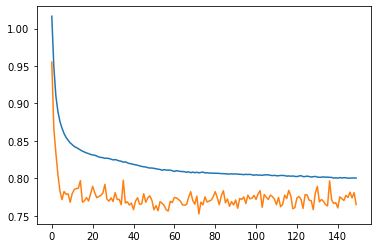

In [8]:
plt.plot(train_loss_AE)
plt.plot(test_loss_AE)

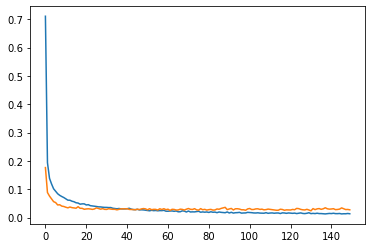

In [9]:
plt.plot(train_loss_dist)
plt.plot(test_loss_dist)

In [10]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

In [11]:
a=[]
y=[]
import time
start_time = time.time()

for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if
        data=data.cuda()
        output=model.encode(data)
        a.append(output.cpu().detach().numpy())
        y.append(target.cpu().detach().numpy())
        

print("--- %s seconds ---" % (time.time() - start_time))

--- 195.50908398628235 seconds ---


In [12]:
X_train=pd.DataFrame(np.array(a).reshape((60000,100)))
y_train=pd.DataFrame(y)

In [13]:
a=[]
y=[]
import time
start_time = time.time()

for batch_i, (data, target) in enumerate(test_loader):
        # move tensors to GPU if
        data=data.cuda()
        output=model.encode(data)
        a.append(output.cpu().detach().numpy())
        y.append(target.cpu().detach().numpy())
        

print("--- %s seconds ---" % (time.time() - start_time))

--- 30.901352882385254 seconds ---


In [14]:
X_test=pd.DataFrame(np.array(a).reshape((10000,100)))
y_test=pd.DataFrame(y)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import StackingClassifier
from sklearn import metrics
names = ["Ensemble Classifier","SVC","LogisticRegression","Nearest Neighbors",
         "Decision Tree", "Random Forest",  "AdaBoost",
         "Naive Bayes", "XGBClassifier"]

-------------------------------------------------------------------------
SVC


C:\Users\vipul\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9931
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      1.00      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


[[ 977    0    1    0    0    0    0    1    1    0]
 [   0 1129    1    1    0    0    3    0    1    0]
 [   1    0 1025    0    1    0    0    4    1    0]
 [   0    0    1 1007    0    2    0    0    0    0]
 [   0    0    1    0

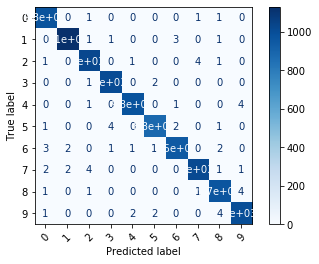

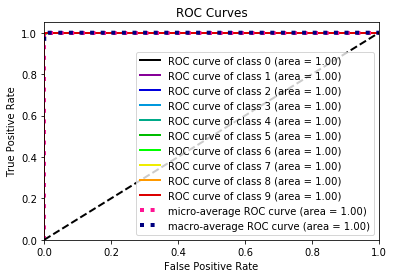

-------------------------------------------------------------------------
LogisticRegression


C:\Users\vipul\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vipul\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9926
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


[[ 975    0    1    0    0    0    2    1    1    0]
 [   0 1131    1    0    0    0    2    0    1    0]
 [   0    0 1026    0    1    0    0    4    1    0]
 [   0    0    1 1005    0    2    0    1    1    0]
 [   0    0    1    0

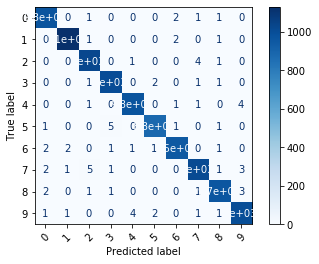

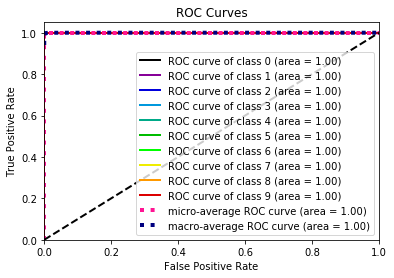

-------------------------------------------------------------------------
Nearest Neighbors


C:\Users\vipul\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.9916
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


[[ 977    0    1    0    0    0    0    1    1    0]
 [   0 1129    1    2    0    0    1    1    1    0]
 [   1    0 1024    0    1    0    0    4    2    0]
 [   0    0    1 1002    0    2    0    2    2    1]
 [   0    0    0    0

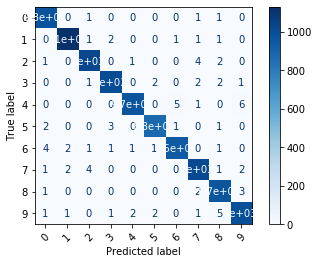

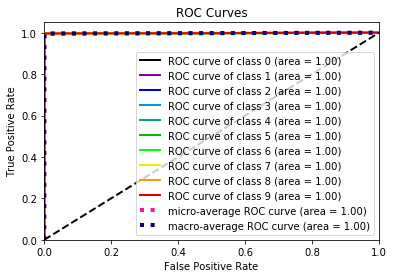

-------------------------------------------------------------------------
Decision Tree
0.9769
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.99      0.97      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


[[ 970    0    0    0    3    0    1    4    1    1]
 [   1 1125    1    4    0    0    2    2    0    0]
 [   3    1 1005    3    3    2    1   

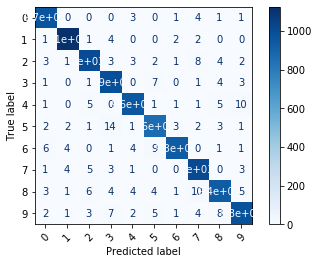

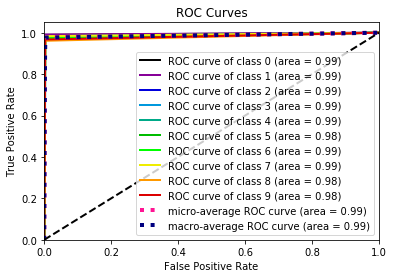

-------------------------------------------------------------------------
Random Forest


C:\Users\vipul\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.9909
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


[[ 976    0    1    0    0    0    0    1    2    0]
 [   0 1130    1    2    0    0    1    0    1    0]
 [   1    0 1025    0    1    0    0    4    1    0]
 [   0    0    1 1005    0    1    0    2    1    0]
 [   0    0    1    0

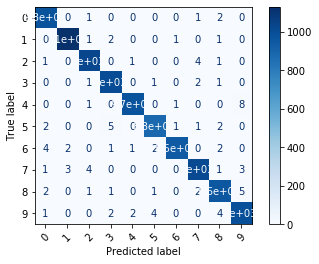

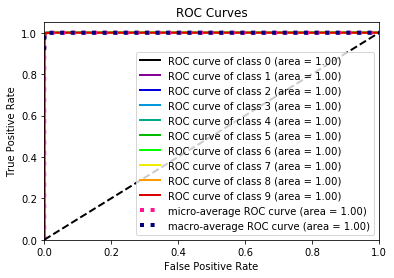

-------------------------------------------------------------------------
AdaBoost


C:\Users\vipul\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6167
              precision    recall  f1-score   support

           0       0.87      0.03      0.07       980
           1       0.71      0.32      0.44      1135
           2       0.89      0.70      0.79      1032
           3       0.85      0.97      0.91      1010
           4       0.89      0.44      0.59       982
           5       0.63      0.87      0.73       892
           6       0.43      0.97      0.60       958
           7       0.47      0.65      0.55      1028
           8       0.45      0.62      0.52       974
           9       0.78      0.64      0.70      1009

    accuracy                           0.62     10000
   macro avg       0.70      0.62      0.59     10000
weighted avg       0.70      0.62      0.59     10000


[[ 34   0   1   0   0   3 940   1   1   0]
 [  0 361  13   0   1   0 153   4 603   0]
 [  1 106 726   0   2   1  10  71 111   4]
 [  0   4   6 983   0   8   1   2   4   2]
 [  1   0  20   1 434  10   1 482   0  33]
 [  0   0   0  15 

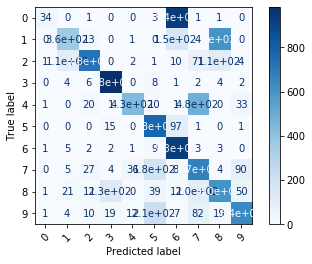

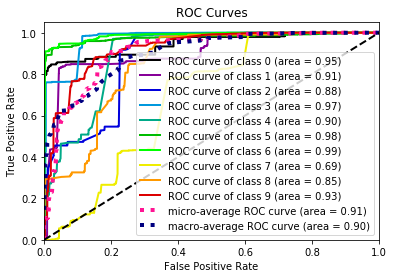

-------------------------------------------------------------------------
XGBClassifier


C:\Users\vipul\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vipul\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.99
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


[[ 973    0    0    0    0    0    3    2    2    0]
 [   0 1128    1    2    0    0    3    0    1    0]
 [   2    0 1023    0    0    0    0    4    3    0]
 [   0    0    1 1004    0    2    0    2    1    0]
 [   0    0    1    0  

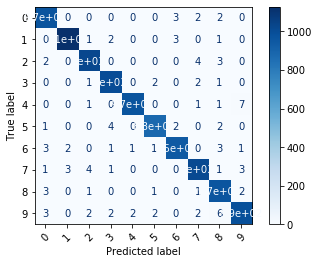

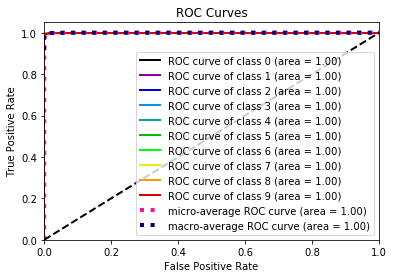

In [16]:
 h= .02  # step size in the mesh
estimators = [('rf', RandomForestClassifier(max_depth=20, n_estimators=100, max_features=1)),
     ('lr',LogisticRegression(max_iter=2000)),
    ('knn',KNeighborsClassifier(3)),
    #('tree',DecisionTreeClassifier(max_depth=5)),
    ('SVC',SVC()),
    #('Adaboost',AdaBoostClassifier()),
    #('GaussNB',GaussianNB()),
    ('XGB',XGBClassifier())]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())
names = [#"Ensemble Classifier",
         "SVC","LogisticRegression","Nearest Neighbors",
         "Decision Tree", "Random Forest",  "AdaBoost",
      #   "Naive Bayes",
    "XGBClassifier"]
#pca1 = PCA(n_components=2)

classifiers = [
    #clf,
    SVC(probability=True),
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
   # GaussianNB(),
    XGBClassifier()]
i1=0
df=pd.DataFrame()
for i,clf in enumerate((classifiers)):
    #scores = cross_val_score(clf, X, y, cv=5)
    print("-------------------------------------------------------------------------")
    print(names[i])
    #print("Scores five fold CV"+str(scores))
    #print("mean score  : "+str(scores.mean()))
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print((accuracy_score(y_test,y_pred)))
    cm=confusion_matrix(y_test, y_pred)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    #print("Precision Score : "+str(precision_score(y_test,y_pred, average=None)))
    #print("Recall Score : "+str(recall_score(y_test,y_pred)) )
    #print(TPR.mean())
    #print(TNR.mean())
    #print((f1_score(y_test,y_pred,average=None)).mean())
    #print(( matthews_corrcoef(y_test, y_pred)))
    #fpr, tpr, thresholds = metrics.roc_auc_score(y_true, y_pred)
    y_pred=clf.predict_proba(X_test)
    #print(metrics.roc_auc_score(y_test, y_pred,multi_class ='ovr'))
    y_pred=clf.predict(X_test)
    #target_names = ['COVID 19', 'NORMAL','Pneumonia']
    print(classification_report(y_test, y_pred))
    titles_options = [("", None)]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,xticks_rotation=45)
        disp.ax_.set_title(title)
        

        print(title)
        print(disp.confusion_matrix)
    #plt.clim(0,450)

    plt.show()
    y_probas =clf.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas)
    plt.show()
    y_score = clf.predict_proba(X_test)
    y_test=y_test
    y_pred = clf.predict(X_test)
    df.loc[i1,'Classifier']=names[i]
    cm=confusion_matrix(y_test, y_pred)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    df.loc[i1,'Acc']=accuracy_score(y_test,y_pred)
    df.loc[i1,'Sens']=TPR.mean()
    df.loc[i1,'Spec']=TNR.mean()
    df.loc[i1,'f1 Score']=(f1_score(y_test,y_pred,average=None)).mean()
    df.loc[i1,'MCC']= matthews_corrcoef(y_test, y_pred)
    df.loc[i1,'AUC']=metrics.roc_auc_score(y_test, y_score,multi_class ='ovr')
    i1=i1+1
    #print(df)
    #clf.fit(X1,y1)
    #plot_decision_regions(X1, y1, classifier=clf)

In [17]:
df

,Classifier,Acc,Sens,Spec,f1 Score,MCC,AUC
0,SVC,0.9931,0.993055,0.999234,0.993059,0.992331,0.999970
1,LogisticRegression,0.9926,0.992539,0.999178,0.992561,0.991775,0.999945
2,Nearest Neighbors,0.9916,0.991566,0.999067,0.991572,0.990664,0.997745
3,Decision Tree,0.9769,0.976564,0.997434,0.976644,0.974329,0.986999
4,Random Forest,0.9909,0.990786,0.998989,0.990825,0.989886,0.999936
5,AdaBoost,0.6167,0.622764,0.957503,0.588889,0.586126,0.902749
6,XGBClassifier,0.9900,0.989954,0.998889,0.989955,0.988886,0.999870


In [18]:
y_train.columns=['value']

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X1=pd.DataFrame(tsne.fit_transform(X_train))

C:\Users\vipul\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


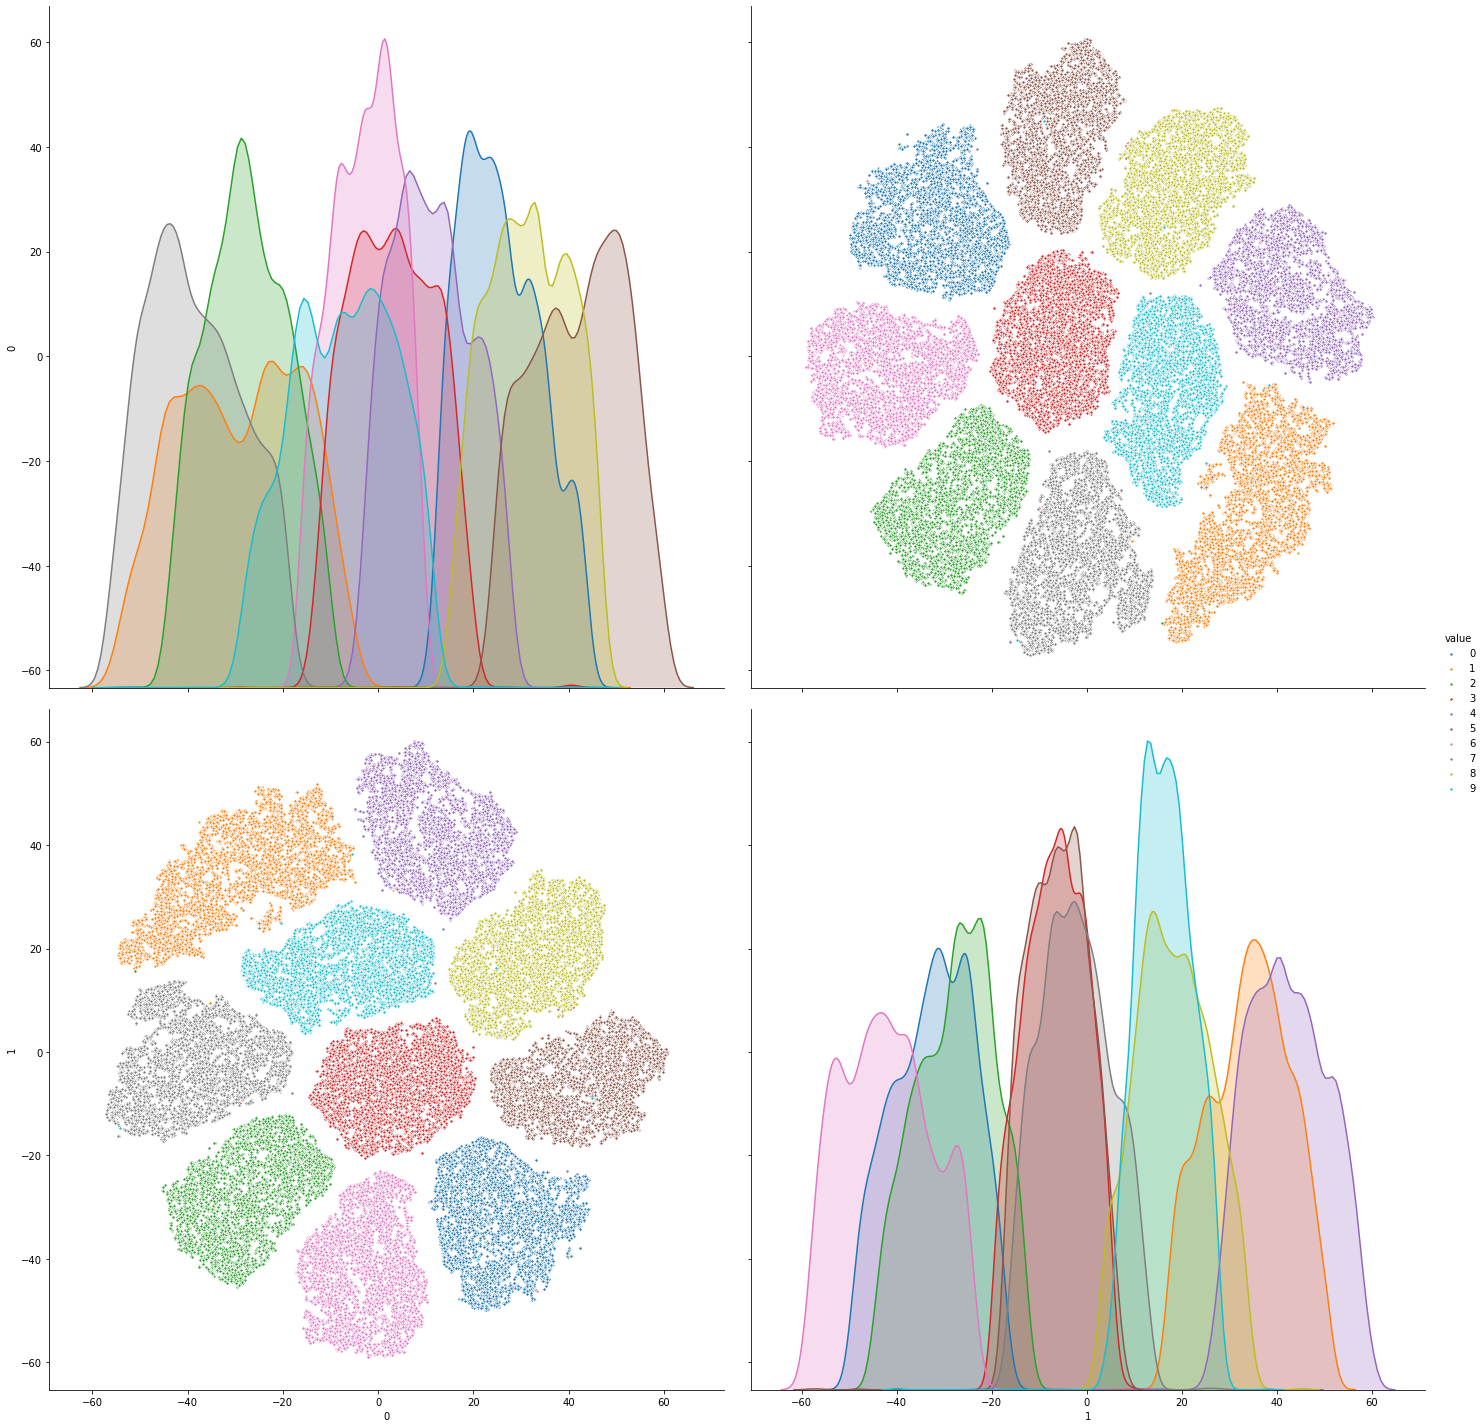

In [27]:
df1=pd.concat([X1,y_train],axis=1)
sns.pairplot(vars=[0,1], data=df1, plot_kws={'s':10}, hue="value",size=10)

In [28]:
torch.save(model.state_dict(), 'models1024/final.pth')